**<center><font size=5>Brain Tumor Detection with Mask R-CNN</font></center>**
<center><img src="https://i.ibb.co/YjpWZ4X/download.png"></center>
***

**Table of Contents**
- <a href='#intro'>1. Project Overview</a> 
- <a href='#env'>2. Setting up the Environment</a>
- <a href='#mrcnn'>3. Mask R-CNN Model</a>
- <a href='#res'>4. Results</a>

# <a id='intro'>1. Project Overview</a>

Previously I have built a CNN model for [Brain Tumor](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection) detection problem: **[Brain Tumor Detection v1.0 || CNN, VGG-16](https://www.kaggle.com/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16)**. It was done using VGG-16 model architecture and pre-trained weights. But it was rather image classificator for **scan with tumor/scan without tumor**. This time I am using [Mask R-CNN](https://github.com/matterport/Mask_RCNN) to build an actual detector which will point out on the location of the tumor on the scan.

For doing this I've added annotations for scans with [VGG Image Annotator (VIA)](http://www.robots.ox.ac.uk/~vgg/software/via/) (just the `yes` folder obviously). I haven't realized that this data set is such a mess. It has a lot of duplicated scans which I tried to remove (not sure that I've removed all of the duplicates though). To make it easy for myself I've added new dataset to [GitHub Repo](https://github.com/ruslan-kl/brain-tumor) which contains of following folders: `annotations` and `train`, `val`, `test` images.

There were some issues with annotations. I couldn't visually detect tumor on some of the scans from `yes` folder (could be caused by the fact that I am not a radiologist or the dataset is not properly assigned). Also on some scans I couldn't figure out which area should be labelled as tumor since it was vague. However, this project is just an example of how you can deal with such task and I will improve it as soon I get more expertise.

# <a id='env'>2. Setting up the Environment</a>

In [1]:
!cd D:\g\Braintumor_masking
# !mkdir noob3

In [2]:
from IPython.display import clear_output
# !git clone https://github.com/matterport/Mask_RCNN.git
# !git clone https://github.com/ruslan-kl/brain-tumor.git
# !pip install pycocotools

# !rm -rf brain-tumor/.git/
# !rm -rf Mask_RCNN/.git/

clear_output()

In [7]:
import os 
import sys
from tqdm import tqdm
import cv2
import numpy as np
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
import random

# Root directory of the project
ROOT_DIR = os.path.abspath('Mask_RCNN/')
# Import Mask RCNN
sys.path.append(ROOT_DIR) 
!dir
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco

plt.rcParams['figure.facecolor'] = 'white'

# clear_output()

 Volume in drive D is Downloads
 Volume Serial Number is 9C1E-DD0F

 Directory of d:\g\Braintumor_masking

29/11/2021  02:07 PM    <DIR>          .
29/11/2021  07:25 PM    <DIR>          ..
23/11/2021  11:49 PM               973 activate.bat
29/11/2021  03:19 PM             8,840 app.py
29/11/2021  02:07 PM    <DIR>          brain-tumor
29/11/2021  07:33 PM         1,592,163 brain-tumor-detection-v2-0-mask-r-cnn.ipynb
29/11/2021  02:07 PM    <DIR>          gui
28/11/2021  01:42 AM    <DIR>          Mask_RCNN
29/11/2021  01:36 PM    <DIR>          static
29/11/2021  01:36 PM    <DIR>          templates
24/11/2021  12:22 AM    <DIR>          tf1_py37
               3 File(s)      1,601,976 bytes
               8 Dir(s)  202,698,264,576 bytes free


Using TensorFlow backend.


In [8]:
def get_ax(rows=1, cols=1, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [9]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs') # directory to save logs and trained model
# ANNOTATIONS_DIR = 'brain-tumor/data/new/annotations/' # directory with annotations for train/val sets
DATASET_DIR = 'brain-tumor/data_cleaned/' # directory with image data
DEFAULT_LOGS_DIR = 'logs' 

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [10]:
class TumorConfig(Config):
    """Configuration for training on the brain tumor dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'tumor_detector'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + tumor
    DETECTION_MIN_CONFIDENCE = 0.85    
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.001
    
config = TumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [11]:
class BrainScanDataset(utils.Dataset):

    def load_brain_scan(self, dataset_dir, subset):
        """Load a subset of the FarmCow dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("tumor", 1, "tumor")

        # Train or validation dataset?
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations_'+subset+'.json')))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "tumor",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a farm_cow dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


# <a id='import'>3. Mask R-CNN Model</a>

In [12]:
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)

model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [14]:
# Training dataset.
dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'val')
dataset_val.prepare()

# Testing dataset
dataset_test = BrainScanDataset()
dataset_test.load_brain_scan(DATASET_DIR, 'test')
dataset_test.prepare()

# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.
print("Training network heads")
# model.train(
#     dataset_train, dataset_val,
#     learning_rate=config.LEARNING_RATE,
#     epochs=15,
#     layers='heads'
# )

Training network heads


In [15]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last() 
model_path = os.path.join(ROOT_DIR, "mask_rcnn_tumor_detector_0015.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  d:\g\Braintumor_masking\Mask_RCNN\mask_rcnn_tumor_detector_0015.h5


In [16]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)

# <a id='res'>4. Results</a>

In [17]:
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

## Validation Set

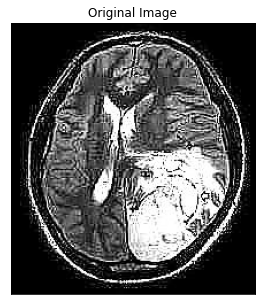

d:\g\Braintumor_masking\tf1_py37\lib\site-packages\ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


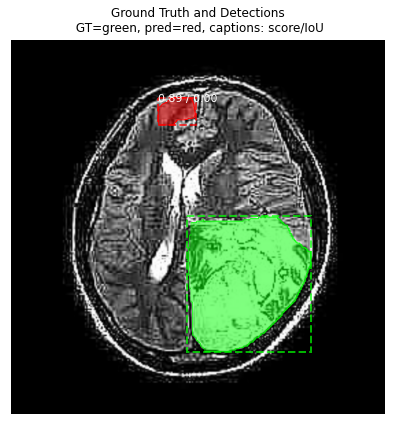

In [18]:
ind = 1
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

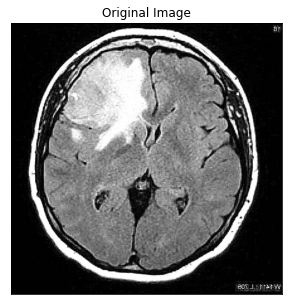

d:\g\Braintumor_masking\tf1_py37\lib\site-packages\ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


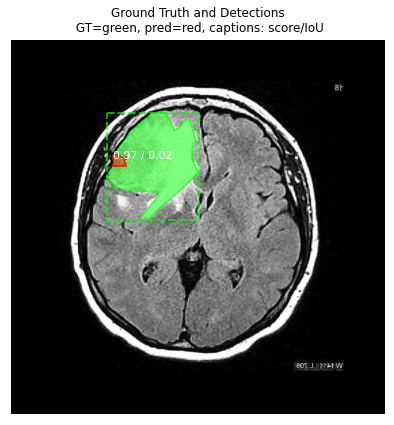

In [19]:
ind = 10
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

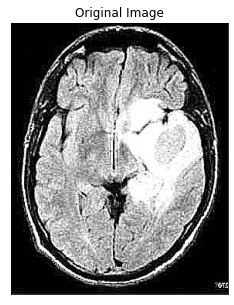

d:\g\Braintumor_masking\tf1_py37\lib\site-packages\ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


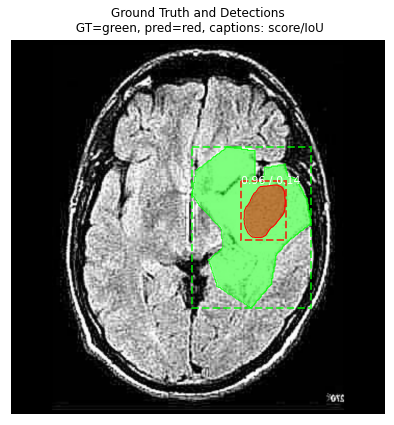

In [20]:
ind = 6
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

## Test Set

Let's see how model performs on images that it hasn't seen before 


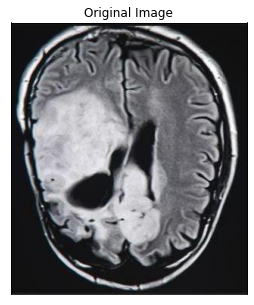

d:\g\Braintumor_masking\tf1_py37\lib\site-packages\ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


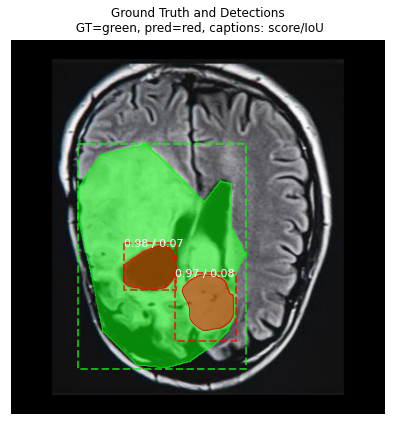

In [34]:
ind = 3
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

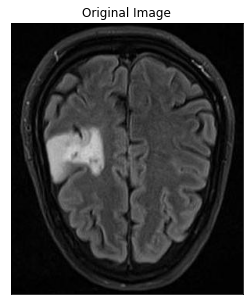

d:\g\Braintumor_masking\tf1_py37\lib\site-packages\ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


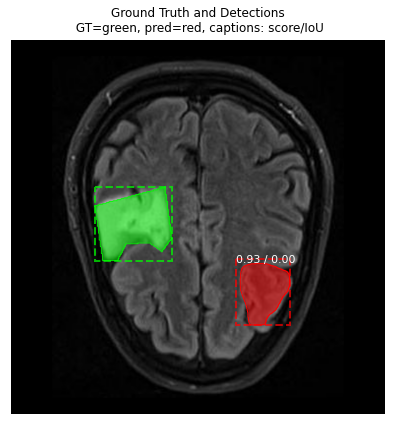

In [29]:
ind = 4
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

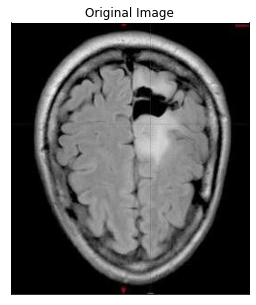

d:\g\Braintumor_masking\tf1_py37\lib\site-packages\ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


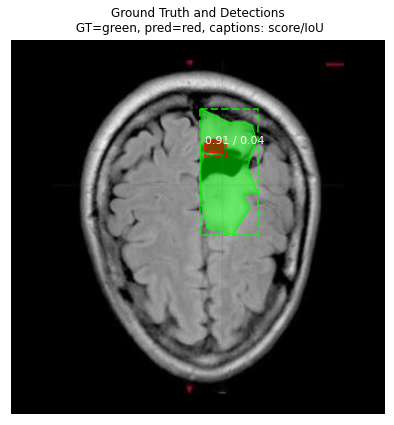

In [41]:
ind = 11
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

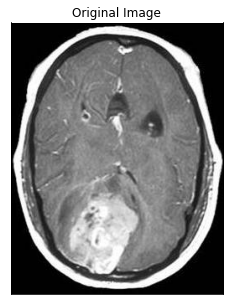

d:\g\Braintumor_masking\tf1_py37\lib\site-packages\ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


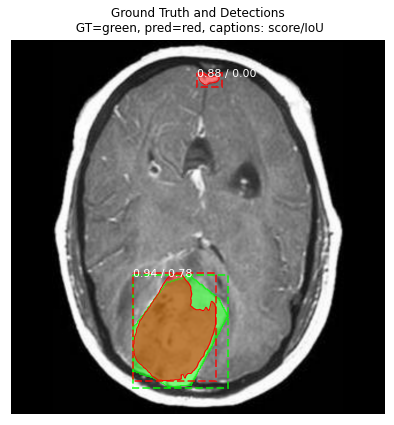

In [42]:
ind = 12
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)